In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.polynomial.legendre import leggauss as roots

from mpl_toolkits import mplot3d
from matplotlib import tri
import matplotlib as mpl
from matplotlib.lines import Line2D
from IPython.display import clear_output

mpl.style.use('default')

In [2]:
class Link():
    def __init__(this,gdl,l,qy1,qy2,ke,kh):
        this.ke = ke
        this.kh = kh
        this.gdl = gdl
        this.ksh = (ke*kh)/(ke-kh)
        this.qy1 = qy1
        this.qy2 = qy2
        this.vp = []
        this.qsh = []
        this.q = []
        this.v = []
        this.kbt = this.ke
        this.l = l
        
        this.vp.append(0)
        this.qsh.append(0)
        this.q.append(0)
        this.v.append(0)
        
        this.P = np.zeros([6,1])
        this.Kb = np.array([[this.kbt,0,0],
                            [0,0,0],
                            [0,0,0]])
        this.c = 1
        this.s = 0
        c = this.c
        s = this.s
        this.t = np.array([[-c,-s/l,-s/l],
                           [-s,c/l,c/l],
                           [0,1,0],
                           [c,s/l,s/l],
                           [s,-s/l,-c/l],
                           [0,0,1]]).T
        this.Ke = this.t.T @ this.Kb @ this.t
        this.Kestado = np.array([[this.Ke[0,0],this.Ke[0,3]],[this.Ke[3,0],this.Ke[3,3]]])
        
        this.Pestado = np.array([[this.P[0][0]],
                                 [this.P[3][0]]])
    def determinarV(this,U):
        this.Ue = U[np.ix_(this.gdl)]
        this.v.append(this.Ue[1][0]-this.Ue[0][0])
    def detEstado(this):
        qtr = this.ke*(this.v[-1]-this.vp[-1])
        fgorro = np.abs(qtr-this.qsh[-1])-this.qy1
        if fgorro < 0:
            this.kbt = this.ke
            this.q.append(qtr)
            this.vp.append(this.vp[-1])
            this.qsh.append(this.qsh[-1])
        else:
            dvp = (fgorro/(this.ke+this.ksh))*np.sign(qtr-this.qsh[-1])
            dqsh = this.ksh*dvp
            this.kbt = this.kh
            qi1 =  qtr-this.ke*dvp#this.q.append()
            if np.abs(qi1) > this.qy2:
                dvp = (fgorro-this.qy2+np.abs(this.q[-1]))/(this.ke)*np.sign(qtr-this.qsh[-1])
                dqsh = (this.qy2-np.abs(this.q[-1]))*np.sign(dvp)
                this.kbt = 0
                qi1 = this.qy2*np.sign(qi1)
            this.q.append(qi1)
            this.vp.append(this.vp[-1]+dvp)
            this.qsh.append(this.qsh[-1]+dqsh)
        this.P = np.array([[-this.q[-1]],
                           [0],
                           [0],
                           [this.q[-1]],
                           [0],
                           [0]])
        this.Kb = np.array([[this.kbt,0,0],
                            [0,0,0],
                            [0,0,0]])
        c = this.c
        s = this.s
        l = this.l
        this.t = np.array([[-c,-s/l,-s/l],
                           [-s,c/l,c/l],
                           [0,1,0],
                           [c,s/l,s/l],
                           [s,-s/l,-c/l],
                           [0,0,1]]).T
        this.Ke = this.t.T @ this.Kb @ this.t
        this.Kestado = np.array([[this.Ke[0,0],this.Ke[0,3]],[this.Ke[3,0],this.Ke[3,3]]])
        this.Pestado = np.array([[this.P[0][0]],
                                 [this.P[3][0]]])

In [80]:
#problema
t = 0
dt = 0.05
masa = 0.259

g = 385.996

cosita = False

z = 0.05

qy1 = 125
qy2 = 125

p1 = -1
p2 = -2

KE = 100#175.2*100
KH = 0#150*100
tiempos = 21
n = 5
L = 4
M = np.identity(n)*masa
uug = lambda t: 0.5*g*np.sin(2*np.pi*t)
ITERNEWT  = 2

diccionarios = []
for i in range(n):
    diccionarios.append([i,i+1])


l = np.zeros([n,1])+1
U = []
U.append(np.zeros([n,1]))
vel = []
vel.append(np.zeros([n,1]))
acel = []
acel.append(np.zeros([n,1]))
Fn = []
Fn.append(np.zeros([n,1]))
F = []
F.append(np.zeros([n,1]))
Pl = []
Pl.append(np.zeros([n,1]))
#EnsamblarKll
Kll = []
k = np.zeros([n+1,n+1])
p = np.zeros([n+1,1])
libres = []
for i in range(n):
    libres.append(i+1)
elementos = []
for i in diccionarios:
    elementos.append(Link(i,L,qy1,qy2,KE,KH))
    e = elementos[-1]
    k[np.ix_(e.gdl,e.gdl)]+=e.Kestado
    p[np.ix_(e.gdl)]+=e.Pestado
klll = k[np.ix_(libres,libres)]
Kll.append(klll)
Pl.append(p[np.ix_(libres)])

eigvl, eigv = np.linalg.eig(np.linalg.inv(M)@Kll)
periodos = np.sqrt(eigvl)

a0 = periodos[0][p1]*periodos[0][p2]/(periodos[0][p1]+periodos[0][p2])*2*z
a1 = z*2/(periodos[0][p1]+periodos[0][p2])

C = a0*M+a1*Kll[-1]

if cosita:
    C = np.array([[64.76535872,-19.97492748,17.48975326,-13.65919406,37.23424098,14.24011698],
     [-19.97492748,82.6602836,-33.81267853,-3.919500626,-65.75142611,-7.189213805],
     [17.48975326,-33.81267853,61.88213369,-19.89199051,27.58662128,-20.76155363],
     [-13.65919406,-3.919500626,-19.89199051,75.57021012,6.554937669,-3.72182691],
     [37.23424098,-65.75142611,27.58662128,6.554937669,62.42013311,9.565010318],
     [14.24011698,-7.189213805,-20.76155363,-3.72182691,9.565010318,41.30117891]])

A = 4/dt*M+C

B = 4/(dt**2)*M+2/dt*C
for i in range(tiempos):
    t = t+dt
    Fn.append(-M@l*uug(t))
    F.append(Fn[-1] + M@acel[-1]+A@vel[-1]+B@U[-1])
    US = U[-1]
    Klll = Kll[-1]
    Pll = Pl[-1]
    for J in range(ITERNEWT):
        Re = F[-1]-Pll[-1]-B@US
        du = np.linalg.pinv(Klll+B)@Re
        US = US+du
        print(np.linalg.norm(Re),'\n',Re,'\n',du,'\n',US)
        clear_output(wait=True)
        k = np.zeros([n+1,n+1])
        p = np.zeros([n+1,1])
        for e in elementos:
            QU = np.array([0]+US.reshape([1,n])[0].tolist()).reshape([n+1,1])
            e.determinarV(QU)
            e.detEstado()
            k[np.ix_(e.gdl,e.gdl)]+=e.Kestado
            p[np.ix_(e.gdl)]+=e.Pestado
        klll = k[np.ix_(libres,libres)]
        Pll = p[np.ix_(libres)]
    U.append(US)
    Kll.append(klll)
    Pl.append(Pll)
    vel.append(2/(dt)*(U[-1]-U[-2])-vel[-1])
    acel.append(4/(dt**2)*(U[-1]-U[-2])-4/dt*vel[-2]-acel[-1])
U

[array([[0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 array([[-0.03398643],
        [-0.03708711],
        [-0.03705993],
        [-0.03694225],
        [-0.03690198]]),
 array([[-0.19386322],
        [-0.21818908],
        [-0.21848169],
        [-0.21749566],
        [-0.21711991]]),
 array([[-0.57463779],
        [-0.67016662],
        [-0.67387755],
        [-0.66987012],
        [-0.66811694]]),
 array([[-1.23036313],
        [-1.48723191],
        [-1.5053154 ],
        [-1.4946789 ],
        [-1.48915683]]),
 array([[-2.17720478],
        [-2.72042789],
        [-2.77718882],
        [-2.75636667],
        [-2.74304932]]),
 array([[-3.44596548],
        [-4.36090504],
        [-4.5034536 ],
        [-4.47633623],
        [-4.45140925]]),
 array([[-5.01342162],
        [-6.36934022],
        [-6.65112266],
        [-6.63112162],
        [-6.59289258]]),
 array([[-6.78576898],
        [-8.67970227],
        [-9.14857588],
        [-9.15442715],
        [-9.10436

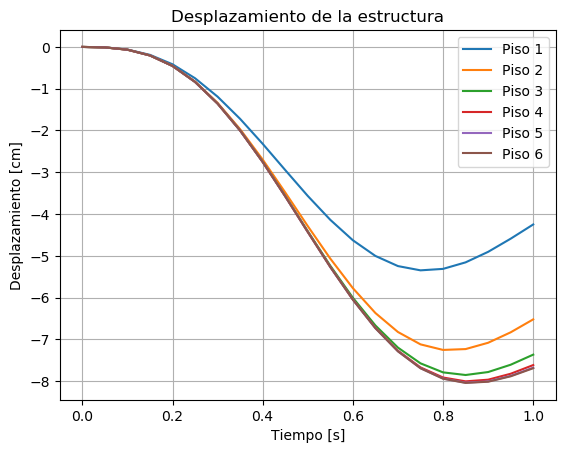

In [123]:
#problema PARAMETROS
t = 0 #Tiempo Inicial, siempre es 0
dt = 0.05 #Paso en el tiempo
masa = 45.63 #Masa por piso

g = 9.81 #Gravedad

cosita = False #Usar matriz C definida por usuario

z = 0.03 #Amortiguamiento objetivo

qy1 = 500 #Primer qy de modelo trilineal
qy2 = 750 #Segundo qy de modelo trilineal

p1 = -2 #Posicion en el arreglo del primer modo
p2 = -1 #Posicion en el arreglo del segundo modo

KE = 40000 #Primera pendiente de la grafica
KH = 15000 #Segunda pendiente de la grafica
tiempoObjetivo = 1#en segundos
tiempos = int(tiempoObjetivo/dt) #Numero de avances en el tiempo a realizar
n = 6 #Numero de pisos
L = 4 #Longitud de piso (no es relevante)

uug = lambda t: 6*g*np.sin(2*np.pi*t) #Funcion de aceleracion en funcion del tiempo
ITERNEWT  = 100 #Numero de iteraciones de Newton por paso

pisoGrafica = 1

#Programa
M = np.identity(n)*masa
diccionarios = []
for i in range(n):
    diccionarios.append([i,i+1])
l = np.zeros([n,1])+1
U = []
U.append(np.zeros([n,1]))
vel = []
vel.append(np.zeros([n,1]))
acel = []
acel.append(np.zeros([n,1]))
Fn = []
Fn.append(np.zeros([n,1]))
F = []
F.append(np.zeros([n,1]))
Pl = []
Pl.append(np.zeros([n,1]))
#EnsamblarKll
Kll = []
k = np.zeros([n+1,n+1])
p = np.zeros([n+1,1])
libres = []
for i in range(n):
    libres.append(i+1)
elementos = []
for i in diccionarios:
    elementos.append(Link(i,L,qy1,qy2,KE,KH))
    e = elementos[-1]
    k[np.ix_(e.gdl,e.gdl)]+=e.Kestado
    p[np.ix_(e.gdl)]+=e.Pestado
klll = k[np.ix_(libres,libres)]
Kll.append(klll)
Pl.append(p[np.ix_(libres)])

eigvl, eigv = np.linalg.eig(np.linalg.inv(M)@Kll)
periodos = np.sqrt(eigvl)

a0 = periodos[0][p1]*periodos[0][p2]/(periodos[0][p1]+periodos[0][p2])*2*z
a1 = z*2/(periodos[0][p1]+periodos[0][p2])

C = a0*M+a1*Kll[-1]

if cosita:
    C = np.array([[64.76535872,-19.97492748,17.48975326,-13.65919406,37.23424098,14.24011698],
     [-19.97492748,82.6602836,-33.81267853,-3.919500626,-65.75142611,-7.189213805],
     [17.48975326,-33.81267853,61.88213369,-19.89199051,27.58662128,-20.76155363],
     [-13.65919406,-3.919500626,-19.89199051,75.57021012,6.554937669,-3.72182691],
     [37.23424098,-65.75142611,27.58662128,6.554937669,62.42013311,9.565010318],
     [14.24011698,-7.189213805,-20.76155363,-3.72182691,9.565010318,41.30117891]])

A = 4/dt*M+C

B = 4/(dt**2)*M+2/dt*C
for i in range(tiempos):
    t = t+dt
    Fn.append(-M@l*uug(t))
    F.append(Fn[-1] + M@acel[-1]+A@vel[-1]+B@U[-1])
    US = U[-1]
    Klll = Kll[-1]
    Pll = Pl[-1]
    for J in range(ITERNEWT):
        Re = F[-1]-Pll[-1]-B@US
        du = np.linalg.pinv(Klll+B)@Re
        US = US+du
        print(np.linalg.norm(Re),'\n',Re,'\n',du,'\n',US)
        clear_output(wait=True)
        k = np.zeros([n+1,n+1])
        p = np.zeros([n+1,1])
        for e in elementos:
            QU = np.array([0]+US.reshape([1,n])[0].tolist()).reshape([n+1,1])
            e.determinarV(QU)
            e.detEstado()
            k[np.ix_(e.gdl,e.gdl)]+=e.Kestado
            p[np.ix_(e.gdl)]+=e.Pestado
        klll = k[np.ix_(libres,libres)]
        Pll = p[np.ix_(libres)]
    U.append(US)
    Kll.append(klll)
    Pl.append(Pll)
    vel.append(2/(dt)*(U[-1]-U[-2])-vel[-1])
    acel.append(4/(dt**2)*(U[-1]-U[-2])-4/dt*vel[-2]-acel[-1])
fig = plt.figure()
ax=fig.add_subplot()
l = []
_X = np.linspace(0,tiempos*dt,tiempos+1)
for i in range(0,n):
    l.append('Piso '+ format(i+1))
    ax.plot(_X,np.array(U).reshape([tiempos+1,6])[:,i])
ax.legend(l)
ax.set_xlabel('Tiempo [s]')
ax.set_ylabel('Desplazamiento [cm]')
ax.set_title('Desplazamiento de la estructura')
ax.grid()
plt.savefig('DespPisos.svg')

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:108: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

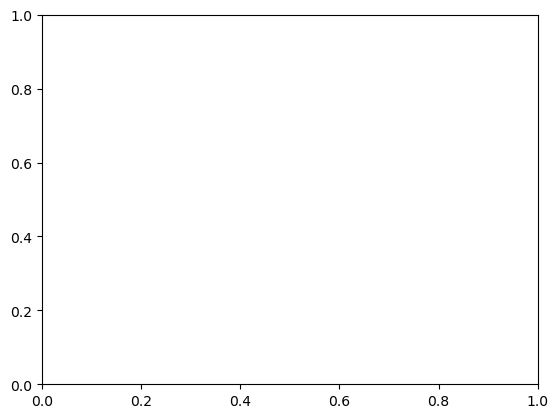

In [137]:
#problema PARAMETROS
t = 0 #Tiempo Inicial, siempre es 0
dt = 0.05 #Paso en el tiempo
masa = 45.63 #Masa por piso

g = 9.81 #Gravedad

cosita = False #Usar matriz C definida por usuario

z = 0.03 #Amortiguamiento objetivo

qy1 = 500 #Primer qy de modelo trilineal
qy2 = 750 #Segundo qy de modelo trilineal

p1 = -2 #Posicion en el arreglo del primer modo
p2 = -1 #Posicion en el arreglo del segundo modo

KE = 40000 #Primera pendiente de la grafica
KH = 15000 #Segunda pendiente de la grafica
tiempoObjetivo = 10#en segundos
tiempos = int(tiempoObjetivo/dt) #Numero de avances en el tiempo a realizar
n = 6 #Numero de pisos
L = 4 #Longitud de piso (no es relevante)

uug = lambda t: 6*g*np.sin(2*np.pi*t) #Funcion de aceleracion en funcion del tiempo
ITERNEWT  = 100 #Numero de iteraciones de Newton por paso

#Programa
M = np.identity(n)*masa
diccionarios = []
for i in range(n):
    diccionarios.append([i,i+1])
l = np.zeros([n,1])+1
U = []
U.append(np.zeros([n,1]))
vel = []
vel.append(np.zeros([n,1]))
acel = []
acel.append(np.zeros([n,1]))
Fn = []
Fn.append(np.zeros([n,1]))
F = []
F.append(np.zeros([n,1]))
Pl = []
Pl.append(np.zeros([n,1]))
#EnsamblarKll
Kll = []
k = np.zeros([n+1,n+1])
p = np.zeros([n+1,1])
libres = []
for i in range(n):
    libres.append(i+1)
elementos = []
for i in diccionarios:
    elementos.append(Link(i,L,qy1,qy2,KE,KH))
    e = elementos[-1]
    k[np.ix_(e.gdl,e.gdl)]+=e.Kestado
    p[np.ix_(e.gdl)]+=e.Pestado
klll = k[np.ix_(libres,libres)]
Kll.append(klll)
Pl.append(p[np.ix_(libres)])

eigvl, eigv = np.linalg.eig(np.linalg.inv(M)@Kll)
periodos = np.sqrt(eigvl)

a0 = periodos[0][p1]*periodos[0][p2]/(periodos[0][p1]+periodos[0][p2])*2*z
a1 = z*2/(periodos[0][p1]+periodos[0][p2])

C = a0*M+a1*Kll[-1]

if cosita:
    C = np.array([[64.76535872,-19.97492748,17.48975326,-13.65919406,37.23424098,14.24011698],
     [-19.97492748,82.6602836,-33.81267853,-3.919500626,-65.75142611,-7.189213805],
     [17.48975326,-33.81267853,61.88213369,-19.89199051,27.58662128,-20.76155363],
     [-13.65919406,-3.919500626,-19.89199051,75.57021012,6.554937669,-3.72182691],
     [37.23424098,-65.75142611,27.58662128,6.554937669,62.42013311,9.565010318],
     [14.24011698,-7.189213805,-20.76155363,-3.72182691,9.565010318,41.30117891]])

A = 4/dt*M+C

B = 4/(dt**2)*M+2/dt*C
for i in range(tiempos):
    t = t+dt
    Fn.append(-M@l*uug(t))
    F.append(Fn[-1] + M@acel[-1]+A@vel[-1]+B@U[-1])
    US = U[-1]
    Klll = Kll[-1]
    Pll = Pl[-1]
    for J in range(ITERNEWT):
        Re = F[-1]-Pll[-1]-B@US
        du = np.linalg.pinv(Klll+B)@Re
        US = US+du
        k = np.zeros([n+1,n+1])
        p = np.zeros([n+1,1])
        for e in elementos:
            QU = np.array([0]+US.reshape([1,n])[0].tolist()).reshape([n+1,1])
            e.determinarV(QU)
            e.detEstado()
            k[np.ix_(e.gdl,e.gdl)]+=e.Kestado
            p[np.ix_(e.gdl)]+=e.Pestado
        klll = k[np.ix_(libres,libres)]
        Pll = p[np.ix_(libres)]
    U.append(US)
    Kll.append(klll)
    Pl.append(Pll)
    vel.append(2/(dt)*(U[-1]-U[-2])-vel[-1])
    acel.append(4/(dt**2)*(U[-1]-U[-2])-4/dt*vel[-2]-acel[-1])
    fig = plt.figure()
    ax=fig.add_subplot()
    leg = []
    _X = np.linspace(0,i*dt,i+2)
    for j in range(0,n):
        leg.append('Piso '+ format(j+1))
        ax.plot(_X,np.array(U).reshape([i+2,6])[:,j])
    ax.legend(l)
    ax.set_xlabel('Tiempo [s]')
    ax.set_ylabel('Desplazamiento [cm]')
    ax.set_title('Desplazamiento de la estructura')
    ax.grid()
    print('Tiempo: ' + format(dt*i))
    plt.clf()
    clear_output(wait=True)
plt.savefig('DespPisos.svg')